In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utility import get_root
import os
import umap
from matplotlib.colors import ListedColormap
import optuna
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


In [31]:
import pandas as pd
import os

path = os.path.join(get_root(), 'data', '231212_Lab data.xlsx')

df = pd.read_excel(path, header=0, skiprows=[1])

expanded_data = []

for i in range(0, len(df), 3):
    feed = df.iloc[i, 2:9].values
    permeat = df.iloc[i+1, 2:9].values
    retentat = df.iloc[i+2, 2:9].values
    sample_value = int(df.iloc[i+2, 9])
    expanded_data.append(list(feed) + list(permeat) + list(retentat) + [sample_value])

columns = [
    f'{label}_{col}' 
    for label in ['Feed', 'Permeat', 'Retentat'] 
    for col in df.columns[2:9]
] + ['Agglomeration class']

expanded_df = pd.DataFrame(expanded_data, columns=columns)

expanded_df



,Feed_Trübung,Feed_pH,Feed_LF,Feed_CSB,Feed_Alkalinität,Feed_Gesamthärte,Feed_Oberflächenspannung,Permeat_Trübung,Permeat_pH,Permeat_LF,...,Permeat_Gesamthärte,Permeat_Oberflächenspannung,Retentat_Trübung,Retentat_pH,Retentat_LF,Retentat_CSB,Retentat_Alkalinität,Retentat_Gesamthärte,Retentat_Oberflächenspannung,Agglomeration class
0,150.0,8.0,2500,200,2.5,15,49,2.0,7.0,1900,...,10,67,200.0,8.5,3100,230,2.8,17,46,1
1,160.0,8.1,2400,210,2.4,16,51,1.5,6.9,1600,...,9,70,190.0,8.6,3200,240,2.9,18,45,2
2,165.0,8.2,2300,220,2.5,14,52,1.7,6.8,1500,...,10,70,195.0,8.7,3300,230,2.8,17,44,2
3,170.0,8.0,2500,215,2.5,15,52,1.8,7.1,1700,...,11,69,210.0,8.5,3100,235,2.8,17,46,2
4,172.0,8.1,2500,220,2.3,16,50,1.5,7.0,1400,...,10,68,205.0,8.5,3300,250,2.7,17,46,2
5,160.0,8.6,2600,220,2.5,14,52,1.0,7.0,1400,...,8,71,210.0,8.8,3400,250,3.0,16,44,3
6,165.0,8.2,2300,220,2.5,14,52,1.7,6.8,1500,...,10,70,195.0,8.7,3300,230,2.8,17,44,2
7,160.0,8.6,2600,220,2.5,14,52,1.0,7.0,1400,...,8,71,210.0,8.8,3400,250,3.0,16,44,3
8,150.0,8.0,2500,200,2.5,15,49,2.0,7.0,1900,...,10,67,200.0,8.5,3100,230,2.8,17,46,1
9,150.0,8.0,2500,200,2.5,15,49,2.0,7.0,1900,...,10,67,200.0,8.5,3100,230,2.8,17,46,1


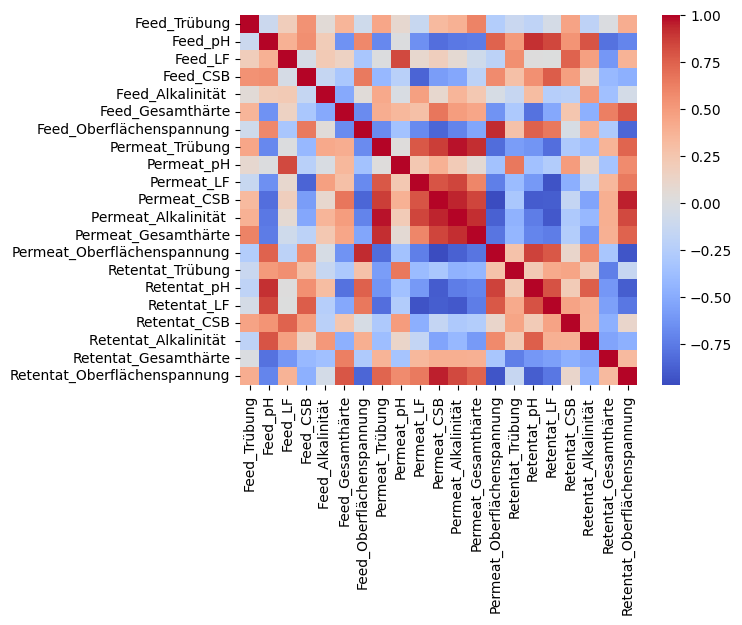

In [32]:
cols_to_plot = expanded_df.columns[:-1]

corr_matrix = expanded_df[cols_to_plot].corr()

sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')

plt.show()


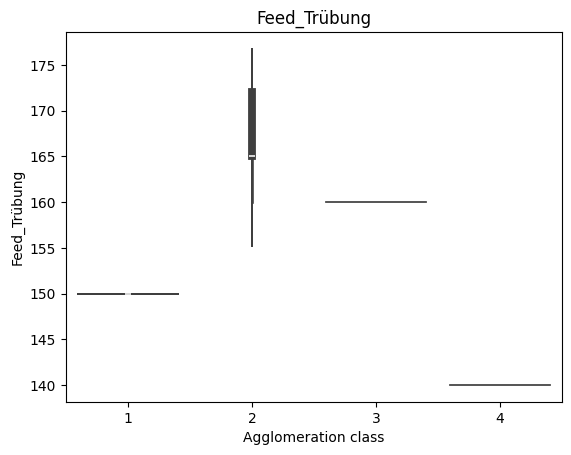

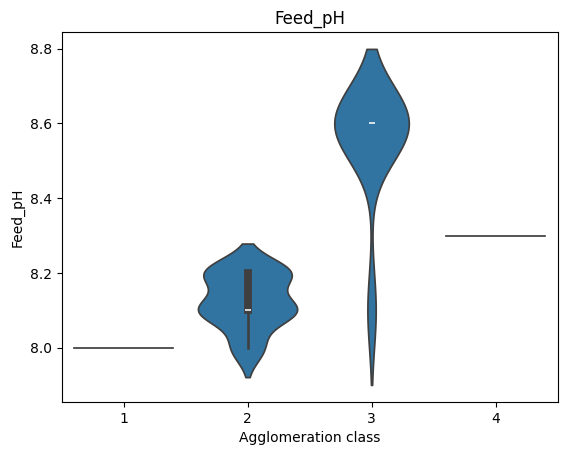

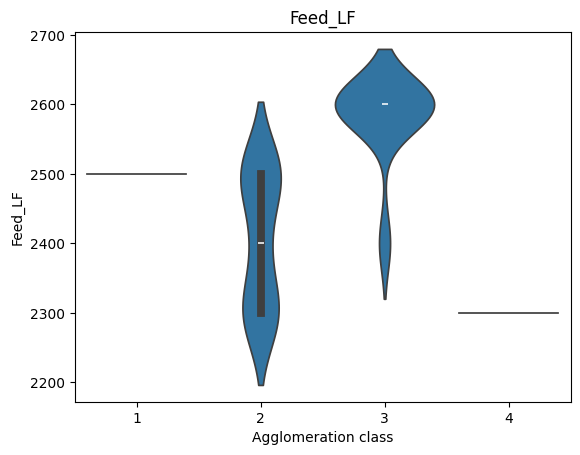

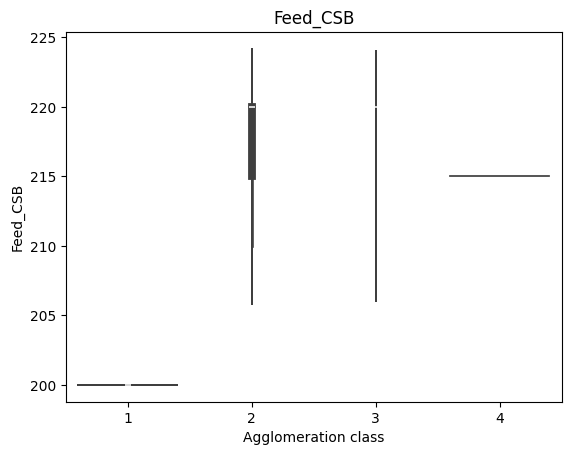

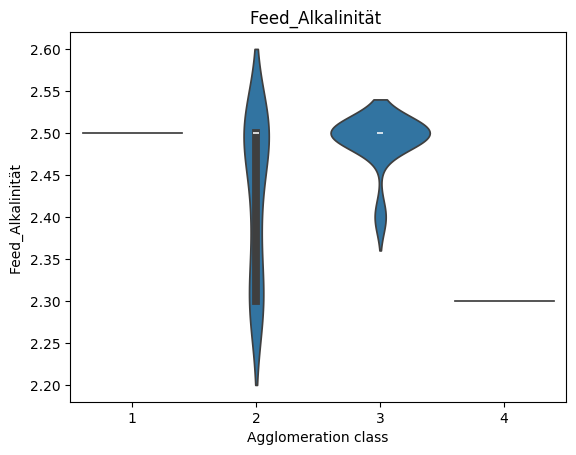

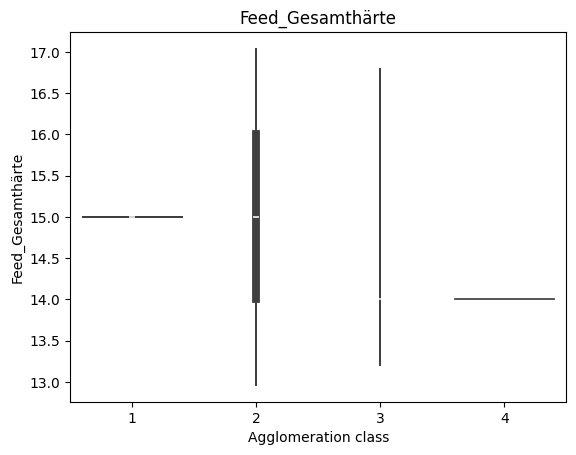

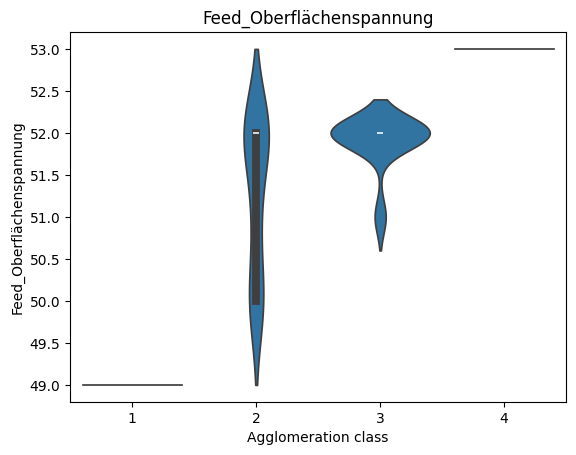

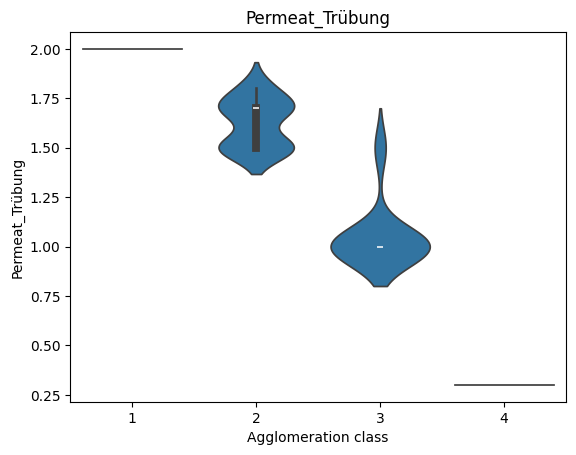

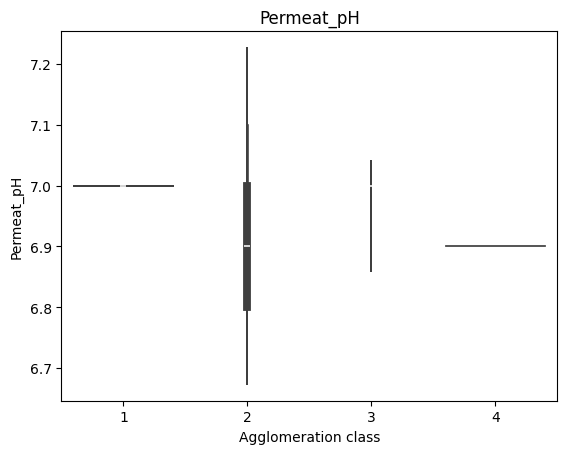

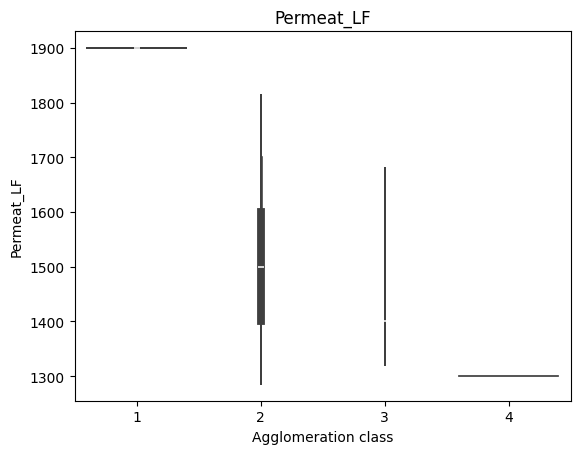

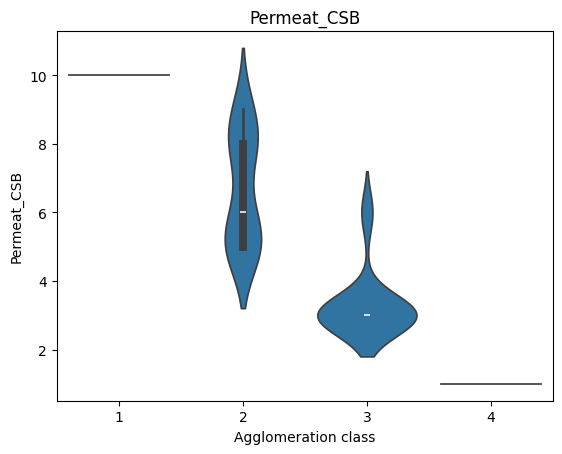

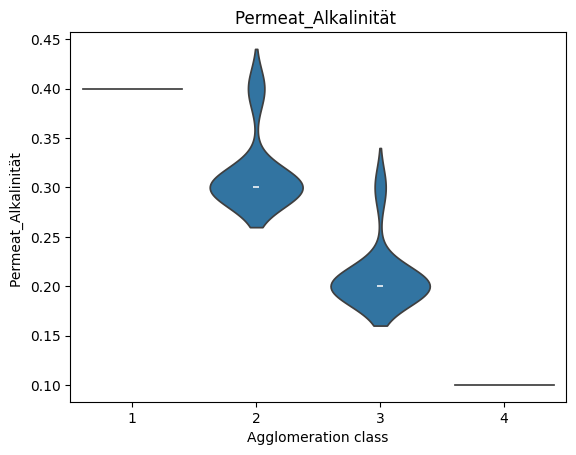

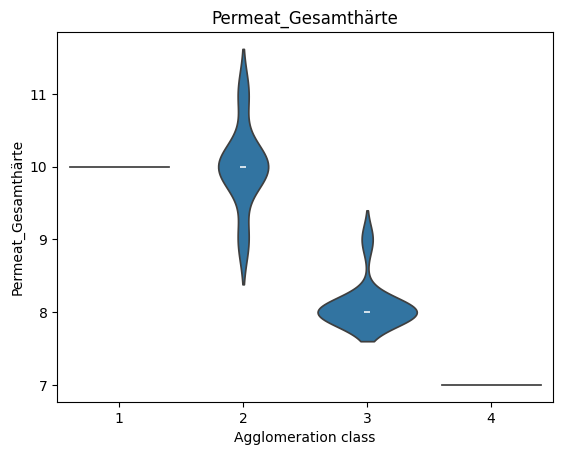

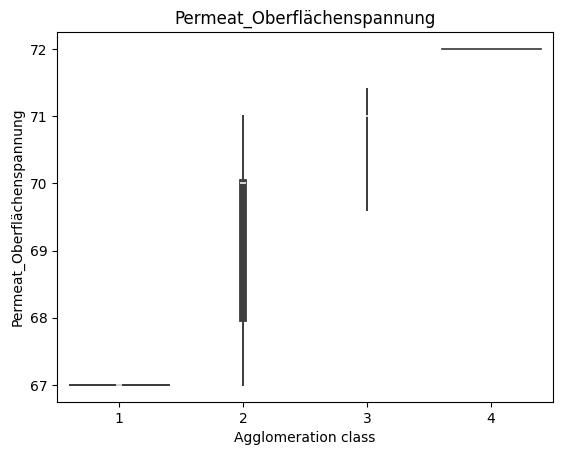

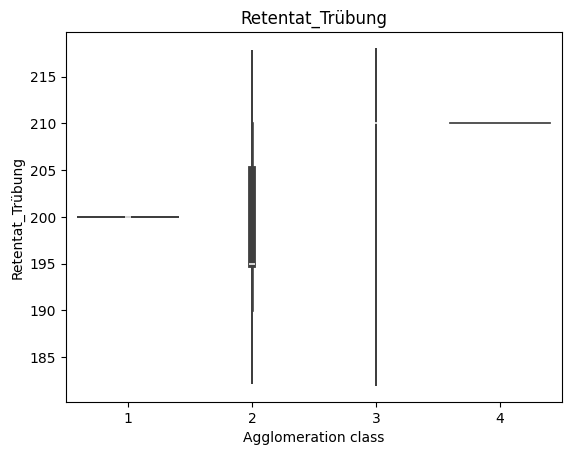

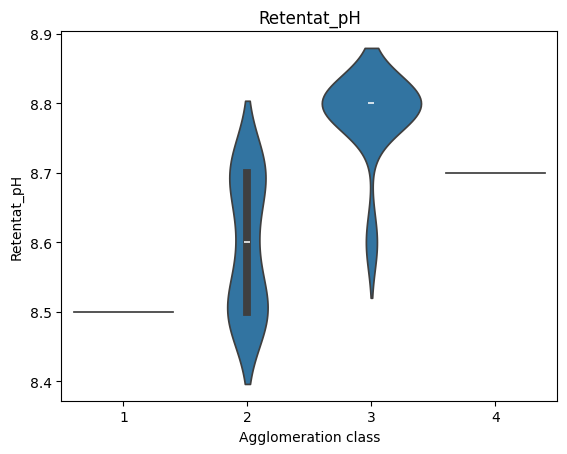

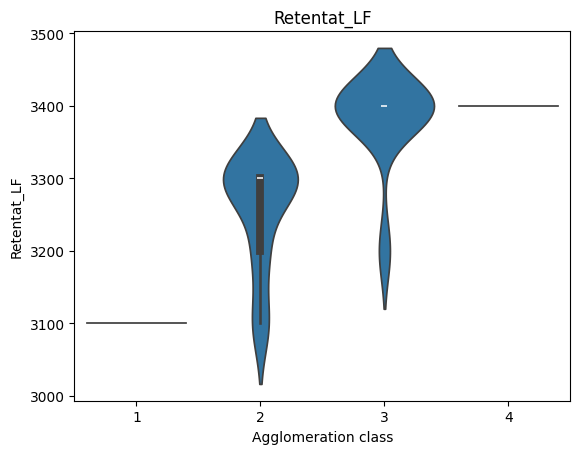

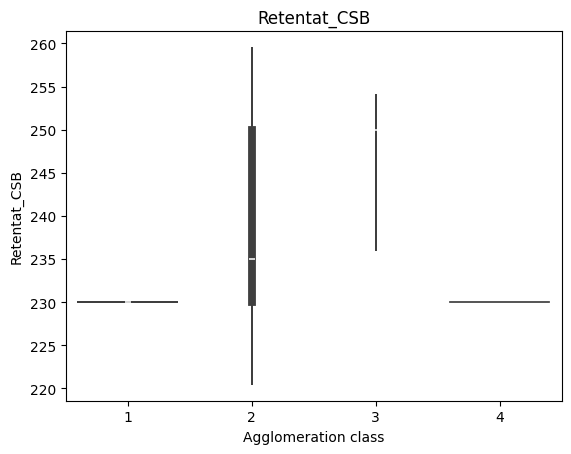

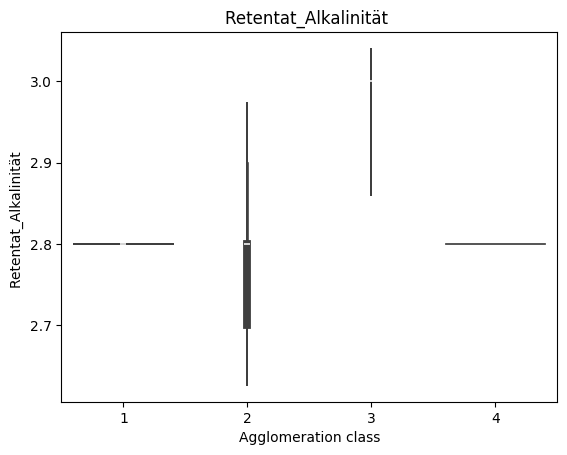

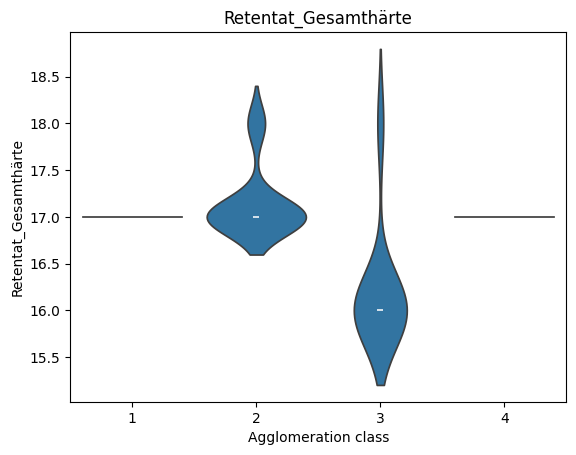

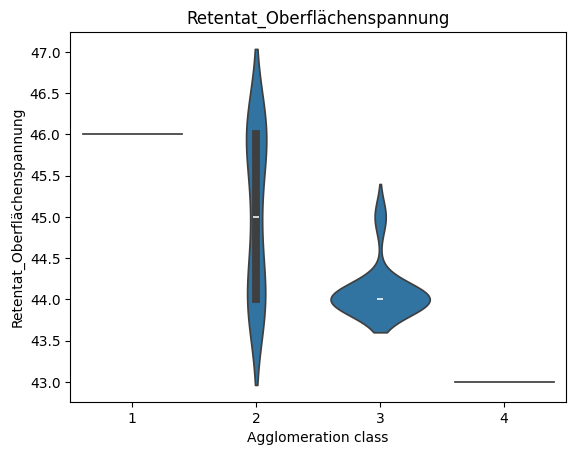

In [33]:
for col in expanded_df.columns[:-1]:
    sns.violinplot(x=expanded_df['Agglomeration class'], y=expanded_df[col])
    plt.title(col)
    plt.show()


/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


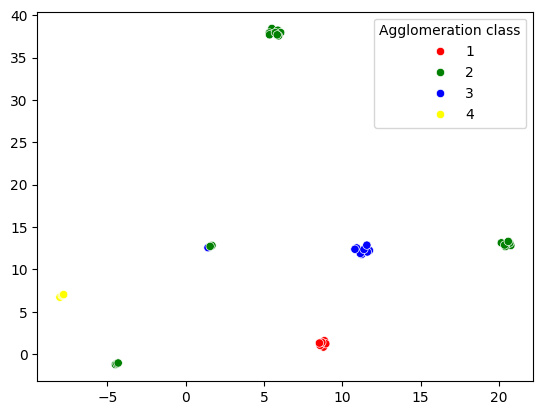

In [34]:
umap_data = umap.UMAP(n_neighbors=3, min_dist=0.1).fit_transform(expanded_df.iloc[:, :-1])

colors = ['red', 'green', 'blue', 'yellow']

cmap = ListedColormap(colors)

sns.scatterplot(x=umap_data[:, 0], y=umap_data[:, 1], hue=expanded_df.iloc[:, -1], palette=colors)

plt.show()


In [35]:
expanded_df['Agglomeration class'].value_counts()


Agglomeration class
2    20
3    10
1     6
4     4
Name: count, dtype: int64

In [40]:
X_train = expanded_df.iloc[:, :-1].values
y_train = expanded_df.iloc[:, -1].values

def objective(trial):
        """
        Objective function for Optuna hyperparameter optimization.

        Args:
            trial (optuna.Trial): Optuna trial object.

        Returns:
            float: Mean absolute error (MAE) for the model.
        """
        f1_list = []
        k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        for train_idx, val_idx in k_fold.split(X_train, y_train):
            model = RandomForestClassifier(
                n_estimators=trial.suggest_int("n_estimators", 2, 10),
                max_depth=trial.suggest_int("max_depth", 2, 5),
                min_samples_split=trial.suggest_int("min_samples_split", 2, 30),
                min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 15),
                max_features=trial.suggest_float("max_features", 0.1, 1),
                bootstrap=trial.suggest_categorical("bootstrap", [True, False]),
            )

            x_train_fold, x_val_fold = (
                X_train[train_idx],
                X_train[val_idx],
            )
            y_train_fold, y_val_fold = (
                y_train[train_idx],
                y_train[val_idx],
            )

            model.fit(x_train_fold, y_train_fold)
            predictions = model.predict(x_val_fold)

            f1 = f1_score(
                y_val_fold, predictions, average='micro'
            )



            f1_list.append(f1)

        return np.mean(f1_list)

sampler = optuna.samplers.TPESampler(seed=42, n_startup_trials=35)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-09-24 18:12:36,407] A new study created in memory with name: no-name-660f6612-e84e-4a50-840f-dded14c640fa
  0%|          | 0/100 [00:00<?, ?it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 0. Best value: 0.5:   1%|          | 1/100 [00:00<00:10,  9.54it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 1. Best value: 0.55:   2%|▏         | 2/100 [00:00<00:15,  6.44it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:36,508] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 5, 'max_depth': 5, 'min_samples_split': 23, 'min_samples_leaf': 9, 'max_features': 0.24041677639819287, 'bootstrap': True}. Best is trial 0 with value: 0.5.
[I 2024-09-24 18:12:36,703] Trial 1 finished with value: 0.55 and parameters: {'n_estimators': 9, 'max_depth': 4, 'min_samples_split': 22, 'min_samples_leaf': 1, 'max_features': 0.9729188669457949, 'bootstrap': True}. Best is trial 1 with value: 0.55.


Best trial: 2. Best value: 0.8:   2%|▏         | 2/100 [00:00<00:15,  6.44it/s] /home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 2. Best value: 0.8:   4%|▍         | 4/100 [00:00<00:10,  9.36it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:   5%|▌         | 5/100 [00:00<00:10,  9.23it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:36,784] Trial 2 finished with value: 0.8 and parameters: {'n_estimators': 3, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 0.48875051677790415, 'bootstrap': False}. Best is trial 2 with value: 0.8.
[I 2024-09-24 18:12:36,857] Trial 3 finished with value: 0.8 and parameters: {'n_estimators': 3, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 0.8066583652537123, 'bootstrap': False}. Best is trial 2 with value: 0.8.
[I 2024-09-24 18:12:36,970] Trial 4 finished with value: 0.9 and parameters: {'n_estimators': 7, 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_features': 0.1585464336867516, 'bootstrap': False}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:   6%|▌         | 6/100 [00:00<00:10,  8.57it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:   6%|▌         | 6/100 [00:00<00:10,  8.57it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:   8%|▊         | 8/100 [00:00<00:09,  9.88it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:37,105] Trial 5 finished with value: 0.65 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 11, 'max_features': 0.4961372443656412, 'bootstrap': False}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:37,170] Trial 6 finished with value: 0.725 and parameters: {'n_estimators': 2, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 0.3805399684804699, 'bootstrap': False}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:37,265] Trial 7 finished with value: 0.475 and parameters: {'n_estimators': 3, 'max_depth': 5, 'min_samples_split': 24, 'min_samples_leaf': 15, 'max_features': 0.905344615384884, 'bootstrap': False}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:   8%|▊         | 8/100 [00:00<00:09,  9.88it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:  10%|█         | 10/100 [00:01<00:08, 10.37it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:37,345] Trial 8 finished with value: 0.775 and parameters: {'n_estimators': 2, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 0.4498095607205338, 'bootstrap': False}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:37,451] Trial 9 finished with value: 0.85 and parameters: {'n_estimators': 5, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 0.8219772826786357, 'bootstrap': False}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:  10%|█         | 10/100 [00:01<00:08, 10.37it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:  12%|█▏        | 12/100 [00:01<00:09,  9.67it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:37,575] Trial 10 finished with value: 0.675 and parameters: {'n_estimators': 8, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 13, 'max_features': 0.7361716094628554, 'bootstrap': False}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:37,681] Trial 11 finished with value: 0.5 and parameters: {'n_estimators': 2, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 13, 'max_features': 0.6609683141448022, 'bootstrap': True}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:  13%|█▎        | 13/100 [00:01<00:08,  9.71it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:  14%|█▍        | 14/100 [00:01<00:09,  8.96it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:37,784] Trial 12 finished with value: 0.5 and parameters: {'n_estimators': 4, 'max_depth': 3, 'min_samples_split': 23, 'min_samples_leaf': 10, 'max_features': 0.8984914683186939, 'bootstrap': True}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:37,925] Trial 13 finished with value: 0.5 and parameters: {'n_estimators': 8, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 12, 'max_features': 0.5444160367279517, 'bootstrap': True}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:  14%|█▍        | 14/100 [00:01<00:09,  8.96it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:  16%|█▌        | 16/100 [00:01<00:08, 10.08it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:37,987] Trial 14 finished with value: 0.675 and parameters: {'n_estimators': 2, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 0.382920382968694, 'bootstrap': False}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:38,085] Trial 15 finished with value: 0.55 and parameters: {'n_estimators': 4, 'max_depth': 3, 'min_samples_split': 23, 'min_samples_leaf': 4, 'max_features': 0.1692819188459137, 'bootstrap': True}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:  16%|█▌        | 16/100 [00:01<00:08, 10.08it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:  18%|█▊        | 18/100 [00:01<00:08,  9.60it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:38,219] Trial 16 finished with value: 0.675 and parameters: {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 14, 'max_features': 0.823304869209203, 'bootstrap': False}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:38,311] Trial 17 finished with value: 0.65 and parameters: {'n_estimators': 6, 'max_depth': 5, 'min_samples_split': 27, 'min_samples_leaf': 5, 'max_features': 0.19904673207490908, 'bootstrap': False}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:  19%|█▉        | 19/100 [00:02<00:09,  8.44it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:  20%|██        | 20/100 [00:02<00:09,  8.70it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:38,485] Trial 18 finished with value: 0.675 and parameters: {'n_estimators': 9, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 0.4756699028339011, 'bootstrap': True}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:38,587] Trial 19 finished with value: 0.8 and parameters: {'n_estimators': 5, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 0.7327170630056601, 'bootstrap': False}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:  21%|██        | 21/100 [00:02<00:09,  8.56it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:  21%|██        | 21/100 [00:02<00:09,  8.56it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:38,709] Trial 20 finished with value: 0.875 and parameters: {'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 0.35635644493972085, 'bootstrap': False}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:38,806] Trial 21 finished with value: 0.65 and parameters: {'n_estimators': 6, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 14, 'max_features': 0.3156057016002752, 'bootstrap': False}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:  23%|██▎       | 23/100 [00:02<00:09,  8.16it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:  24%|██▍       | 24/100 [00:02<00:09,  7.93it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:38,972] Trial 22 finished with value: 0.5 and parameters: {'n_estimators': 10, 'max_depth': 2, 'min_samples_split': 21, 'min_samples_leaf': 12, 'max_features': 0.3138737895931597, 'bootstrap': True}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:39,111] Trial 23 finished with value: 0.7 and parameters: {'n_estimators': 7, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 0.8517722460303142, 'bootstrap': True}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:  24%|██▍       | 24/100 [00:02<00:09,  7.93it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:  26%|██▌       | 26/100 [00:02<00:08,  9.02it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:39,173] Trial 24 finished with value: 0.8 and parameters: {'n_estimators': 2, 'max_depth': 4, 'min_samples_split': 21, 'min_samples_leaf': 1, 'max_features': 0.5608837524693528, 'bootstrap': False}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:39,283] Trial 25 finished with value: 0.5 and parameters: {'n_estimators': 3, 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 15, 'max_features': 0.22376884973139394, 'bootstrap': True}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:  27%|██▋       | 27/100 [00:03<00:09,  8.10it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:  27%|██▋       | 27/100 [00:03<00:09,  8.10it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:39,454] Trial 26 finished with value: 0.625 and parameters: {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 0.8354999801810943, 'bootstrap': True}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:39,538] Trial 27 finished with value: 0.65 and parameters: {'n_estimators': 4, 'max_depth': 2, 'min_samples_split': 28, 'min_samples_leaf': 14, 'max_features': 0.6697913115459412, 'bootstrap': False}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:  29%|██▉       | 29/100 [00:03<00:08,  8.60it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:  30%|███       | 30/100 [00:03<00:08,  8.12it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:39,663] Trial 28 finished with value: 0.675 and parameters: {'n_estimators': 8, 'max_depth': 5, 'min_samples_split': 27, 'min_samples_leaf': 12, 'max_features': 0.677828481538859, 'bootstrap': False}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:39,811] Trial 29 finished with value: 0.9 and parameters: {'n_estimators': 10, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.6971515921972502, 'bootstrap': False}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:  30%|███       | 30/100 [00:03<00:08,  8.12it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:  32%|███▏      | 32/100 [00:03<00:07,  8.65it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:  32%|███▏      | 32/100 [00:03<00:07,  8.65it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:39,910] Trial 30 finished with value: 0.775 and parameters: {'n_estimators': 6, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 0.7409612992127823, 'bootstrap': False}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:40,018] Trial 31 finished with value: 0.65 and parameters: {'n_estimators': 8, 'max_depth': 4, 'min_samples_split': 26, 'min_samples_leaf': 10, 'max_features': 0.6114777430019245, 'bootstrap': False}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:40,091] Trial 32 finished with value: 0.65 and parameters: {'n_estimators': 4, 'max_depth': 2, 'min_samples_split': 30, 'min_samples_leaf': 6, 'max_features': 0.902841899659402, 'bootstrap': False}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:  34%|███▍      | 34/100 [00:03<00:07,  8.92it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:  35%|███▌      | 35/100 [00:03<00:07,  8.68it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:40,229] Trial 33 finished with value: 0.675 and parameters: {'n_estimators': 6, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': 0.7502069037353548, 'bootstrap': True}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:40,357] Trial 34 finished with value: 0.5 and parameters: {'n_estimators': 7, 'max_depth': 2, 'min_samples_split': 29, 'min_samples_leaf': 15, 'max_features': 0.9233779511984037, 'bootstrap': True}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:  36%|███▌      | 36/100 [00:04<00:08,  7.67it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:  37%|███▋      | 37/100 [00:04<00:09,  6.93it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:40,540] Trial 35 finished with value: 0.875 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 0.28532411064210905, 'bootstrap': False}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:40,729] Trial 36 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 0.11765967308500577, 'bootstrap': False}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:  38%|███▊      | 38/100 [00:04<00:09,  6.56it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:  39%|███▉      | 39/100 [00:04<00:09,  6.29it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:40,905] Trial 37 finished with value: 0.9 and parameters: {'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 0.10575850439769557, 'bootstrap': False}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:41,080] Trial 38 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 0.1184250543018222, 'bootstrap': False}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:  40%|████      | 40/100 [00:04<00:09,  6.21it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:  41%|████      | 41/100 [00:05<00:09,  5.99it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:41,247] Trial 39 finished with value: 0.9 and parameters: {'n_estimators': 7, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.1254148490743692, 'bootstrap': False}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:41,430] Trial 40 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 0.16229263573316974, 'bootstrap': False}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:  42%|████▏     | 42/100 [00:05<00:10,  5.76it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:41,620] Trial 41 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 0.11479650580992316, 'bootstrap': False}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:  43%|████▎     | 43/100 [00:05<00:10,  5.44it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 4. Best value: 0.9:  44%|████▍     | 44/100 [00:05<00:10,  5.43it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:41,828] Trial 42 finished with value: 0.9 and parameters: {'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.11423729829167598, 'bootstrap': False}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:42,013] Trial 43 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.2543043295460051, 'bootstrap': False}. Best is trial 4 with value: 0.9.


Best trial: 4. Best value: 0.9:  45%|████▌     | 45/100 [00:05<00:10,  5.49it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  46%|████▌     | 46/100 [00:05<00:09,  5.42it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:42,190] Trial 44 finished with value: 0.9 and parameters: {'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 0.17471958584165653, 'bootstrap': False}. Best is trial 4 with value: 0.9.
[I 2024-09-24 18:12:42,378] Trial 45 finished with value: 0.975 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.10138965722526412, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  47%|████▋     | 47/100 [00:06<00:09,  5.36it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  48%|████▊     | 48/100 [00:06<00:09,  5.31it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:42,570] Trial 46 finished with value: 0.85 and parameters: {'n_estimators': 8, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 0.22715899467066122, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:42,764] Trial 47 finished with value: 0.9 and parameters: {'n_estimators': 10, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.15064998294588153, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  49%|████▉     | 49/100 [00:06<00:09,  5.54it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  50%|█████     | 50/100 [00:06<00:08,  5.75it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:42,926] Trial 48 finished with value: 0.75 and parameters: {'n_estimators': 8, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 0.19821315888804236, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:43,085] Trial 49 finished with value: 0.9 and parameters: {'n_estimators': 7, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 0.28003183931978803, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  51%|█████     | 51/100 [00:06<00:08,  5.47it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  52%|█████▏    | 52/100 [00:07<00:08,  5.53it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:43,289] Trial 50 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 0.21435368061508825, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:43,464] Trial 51 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 0.10566971745743788, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  53%|█████▎    | 53/100 [00:07<00:08,  5.52it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  54%|█████▍    | 54/100 [00:07<00:08,  5.40it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:43,647] Trial 52 finished with value: 0.9 and parameters: {'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.14646221594176828, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:43,841] Trial 53 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 0.4230003426339334, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  55%|█████▌    | 55/100 [00:07<00:08,  5.39it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  56%|█████▌    | 56/100 [00:07<00:08,  5.47it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:44,028] Trial 54 finished with value: 0.9 and parameters: {'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 0.17359613489031553, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:44,204] Trial 55 finished with value: 0.975 and parameters: {'n_estimators': 9, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 0.10271951335853825, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  57%|█████▋    | 57/100 [00:07<00:07,  5.46it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:44,388] Trial 56 finished with value: 0.85 and parameters: {'n_estimators': 8, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.25403188336329835, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  58%|█████▊    | 58/100 [00:08<00:08,  4.90it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  59%|█████▉    | 59/100 [00:08<00:08,  5.05it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:44,640] Trial 57 finished with value: 0.875 and parameters: {'n_estimators': 9, 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_features': 0.10086163904464202, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:44,826] Trial 58 finished with value: 0.75 and parameters: {'n_estimators': 10, 'max_depth': 2, 'min_samples_split': 24, 'min_samples_leaf': 6, 'max_features': 0.20303198192303018, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  60%|██████    | 60/100 [00:08<00:07,  5.06it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  61%|██████    | 61/100 [00:08<00:07,  5.26it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:45,021] Trial 59 finished with value: 0.875 and parameters: {'n_estimators': 10, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 0.1383614246443397, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:45,194] Trial 60 finished with value: 0.825 and parameters: {'n_estimators': 8, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 0.5301841010116985, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  62%|██████▏   | 62/100 [00:08<00:07,  5.32it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:45,375] Trial 61 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 0.1841547635016782, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  63%|██████▎   | 63/100 [00:09<00:07,  5.19it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  64%|██████▍   | 64/100 [00:09<00:06,  5.22it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:45,579] Trial 62 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.13639507633203304, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:45,770] Trial 63 finished with value: 0.975 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.10412589452052554, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  65%|██████▌   | 65/100 [00:09<00:06,  5.31it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:45,950] Trial 64 finished with value: 0.9 and parameters: {'n_estimators': 8, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.15645431203297352, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  66%|██████▌   | 66/100 [00:09<00:06,  5.15it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  67%|██████▋   | 67/100 [00:09<00:06,  5.39it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:46,155] Trial 65 finished with value: 0.825 and parameters: {'n_estimators': 10, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 0.6142341095029749, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:46,324] Trial 66 finished with value: 0.7 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 0.19313016493267787, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  68%|██████▊   | 68/100 [00:10<00:06,  5.09it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  69%|██████▉   | 69/100 [00:10<00:05,  5.41it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:46,545] Trial 67 finished with value: 0.9 and parameters: {'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.1001189359832144, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:46,703] Trial 68 finished with value: 0.8 and parameters: {'n_estimators': 5, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.7879927233742924, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  70%|███████   | 70/100 [00:10<00:05,  5.58it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:46,870] Trial 69 finished with value: 0.875 and parameters: {'n_estimators': 8, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 0.3432432703724849, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  71%|███████   | 71/100 [00:10<00:05,  4.90it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  72%|███████▏  | 72/100 [00:10<00:05,  5.11it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:47,132] Trial 70 finished with value: 0.825 and parameters: {'n_estimators': 10, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 0.23659433267007532, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:47,308] Trial 71 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 0.1294544630703896, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  73%|███████▎  | 73/100 [00:11<00:05,  5.06it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  74%|███████▍  | 74/100 [00:11<00:04,  5.32it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:47,508] Trial 72 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.13665321771284486, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:47,675] Trial 73 finished with value: 0.9 and parameters: {'n_estimators': 7, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.1692307223233233, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  75%|███████▌  | 75/100 [00:11<00:04,  5.23it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  76%|███████▌  | 76/100 [00:11<00:04,  5.37it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:47,875] Trial 74 finished with value: 0.975 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 0.10207131818233853, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:48,049] Trial 75 finished with value: 0.8 and parameters: {'n_estimators': 8, 'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 0.7055638418564588, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  77%|███████▋  | 77/100 [00:11<00:04,  5.04it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  78%|███████▊  | 78/100 [00:12<00:04,  5.26it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:48,277] Trial 76 finished with value: 0.875 and parameters: {'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 0.9836686568317432, 'bootstrap': True}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:48,445] Trial 77 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 0.10110223982514527, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  79%|███████▉  | 79/100 [00:12<00:03,  5.31it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  80%|████████  | 80/100 [00:12<00:03,  5.35it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:48,630] Trial 78 finished with value: 0.875 and parameters: {'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 0.15783271220447156, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:48,815] Trial 79 finished with value: 0.975 and parameters: {'n_estimators': 8, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.2802260941018418, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  81%|████████  | 81/100 [00:12<00:03,  5.66it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  82%|████████▏ | 82/100 [00:12<00:03,  5.73it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:48,968] Trial 80 finished with value: 0.825 and parameters: {'n_estimators': 7, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.2765503942531322, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:49,137] Trial 81 finished with value: 0.875 and parameters: {'n_estimators': 8, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.1283763914406817, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  83%|████████▎ | 83/100 [00:12<00:03,  5.59it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  84%|████████▍ | 84/100 [00:13<00:02,  5.53it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:49,325] Trial 82 finished with value: 0.85 and parameters: {'n_estimators': 9, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.21274092633721411, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:49,512] Trial 83 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.1826291578281904, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  85%|████████▌ | 85/100 [00:13<00:02,  5.62it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:49,683] Trial 84 finished with value: 0.9 and parameters: {'n_estimators': 7, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.15057157529862975, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  86%|████████▌ | 86/100 [00:13<00:02,  5.31it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:49,895] Trial 85 finished with value: 0.75 and parameters: {'n_estimators': 8, 'max_depth': 2, 'min_samples_split': 22, 'min_samples_leaf': 1, 'max_features': 0.4168252879466231, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  87%|████████▋ | 87/100 [00:13<00:02,  4.80it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  88%|████████▊ | 88/100 [00:13<00:02,  5.07it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:50,149] Trial 86 finished with value: 0.85 and parameters: {'n_estimators': 9, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.12719132471771566, 'bootstrap': True}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:50,320] Trial 87 finished with value: 0.9 and parameters: {'n_estimators': 8, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 0.5949380731513759, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  89%|████████▉ | 89/100 [00:14<00:02,  5.15it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  90%|█████████ | 90/100 [00:14<00:01,  5.20it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:50,508] Trial 88 finished with value: 0.8 and parameters: {'n_estimators': 10, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.31557058168808916, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:50,696] Trial 89 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 0.24541258336091318, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  91%|█████████ | 91/100 [00:14<00:01,  5.26it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:50,880] Trial 90 finished with value: 0.875 and parameters: {'n_estimators': 8, 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_features': 0.1186336047473602, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  92%|█████████▏| 92/100 [00:14<00:01,  5.17it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  93%|█████████▎| 93/100 [00:14<00:01,  5.17it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:51,081] Trial 91 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 0.1597146132886727, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:51,275] Trial 92 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 0.11730122620429165, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  94%|█████████▍| 94/100 [00:15<00:01,  5.13it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:51,473] Trial 93 finished with value: 0.9 and parameters: {'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.19250410500591508, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  95%|█████████▌| 95/100 [00:15<00:01,  4.96it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:51,689] Trial 94 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.1403043906296798, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  96%|█████████▌| 96/100 [00:15<00:00,  4.55it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  97%|█████████▋| 97/100 [00:15<00:00,  4.77it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:51,949] Trial 95 finished with value: 0.9 and parameters: {'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.17236716826156467, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:52,139] Trial 96 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 0.1154571995615466, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975:  98%|█████████▊| 98/100 [00:15<00:00,  4.81it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
Best trial: 45. Best value: 0.975:  99%|█████████▉| 99/100 [00:16<00:00,  5.26it/s]/home/illia/PycharmProjects/AIMFiltech/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[I 2024-09-24 18:12:52,343] Trial 97 finished with value: 0.9 and parameters: {'n_estimators': 8, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.8754582158221466, 'bootstrap': False}. Best is trial 45 with value: 0.975.
[I 2024-09-24 18:12:52,492] Trial 98 finished with value: 0.725 and parameters: {'n_estimators': 6, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 11, 'max_features': 0.10116924978916307, 'bootstrap': False}. Best is trial 45 with value: 0.975.


Best trial: 45. Best value: 0.975: 100%|██████████| 100/100 [00:16<00:00,  6.13it/s]

[I 2024-09-24 18:12:52,707] Trial 99 finished with value: 0.9 and parameters: {'n_estimators': 9, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.9579073560192595, 'bootstrap': True}. Best is trial 45 with value: 0.975.
